550 Final:
wildfire data preprocess

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive


In [ ]:
!apt update

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://security.ubuntu.com/ubuntu 

In [ ]:
# mount your drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
clean_fires_df=pd.read_csv('/content/drive/MyDrive/reduced_fires.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
!pip install pyshp
!pip install shapely
!!pip install --upgrade geopandas
import geopandas as gpd
import shapefile
from shapely.geometry import Point # Point class
from shapely.geometry import shape # shape() is a function to convert geo objects through the interface

shp = shapefile.Reader('/content/drive/MyDrive/NPS_-_Land_Resources_Division_Boundary_and_Tract_Data_Service.shp') #open the shapefile
shx = shapefile.Reader('/content/drive/MyDrive/NPS_-_Land_Resources_Division_Boundary_and_Tract_Data_Service.shx')
dbf = shapefile.Reader('/content/drive/MyDrive/NPS_-_Land_Resources_Division_Boundary_and_Tract_Data_Service.dbf')
cpg = shapefile.Reader('/content/drive/MyDrive/NPS_-_Land_Resources_Division_Boundary_and_Tract_Data_Service.cpg')
prj = shapefile.Reader('/content/drive/MyDrive/NPS_-_Land_Resources_Division_Boundary_and_Tract_Data_Service.prj')
all_shapes = shp.shapes() # get all the polygons
all_records = shp.records() 

from shapely import geometry


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 3.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
nps = gpd.read_file('/content/drive/MyDrive/NPS_-_Land_Resources_Division_Boundary_and_Tract_Data_Service.shp')
nps = nps.to_crs(epsg=4326) ### coordinate transfer

In [ ]:
nps.geometry

0      POLYGON ((-106.45326 36.00847, -106.44882 36.0...
1      MULTIPOLYGON (((-91.40321 37.15886, -91.40323 ...
2      POLYGON ((-93.41641 37.11999, -93.41642 37.119...
3      MULTIPOLYGON (((-90.04187 37.97647, -90.04206 ...
4      POLYGON ((-96.31933 44.00871, -96.32106 44.008...
                             ...                        
423    MULTIPOLYGON (((-84.61253 37.78451, -84.61379 ...
424    POLYGON ((-121.37083 41.88762, -121.37160 41.8...
425    MULTIPOLYGON (((-90.21252 32.34110, -90.21254 ...
426    MULTIPOLYGON (((-84.77822 36.91738, -84.77823 ...
427    POLYGON ((-77.01772 38.88747, -77.01772 38.887...
Name: geometry, Length: 428, dtype: geometry

In [ ]:
point_list=gpd.points_from_xy([1],[1])

In [ ]:
point_list

<GeometryArray>
Length: 1, dtype: geometry

In [ ]:
polygons=[]
for i in range(len(all_shapes)):
    poly = geometry.Polygon(all_shapes[i].points)
    polygons.append(poly)

def place(s,x,y):
  z='out'  # default to not in any geometry # an x,y tuple
  p=gpd.points_from_xy([x],[y])    
  for i in range(len(all_shapes)):
    if s!= all_records[i][11]:
      continue
    if p.within(nps.geometry[i])[0]: # make a point and see if it's in the polygon
      z = all_records[i][9]
      break; # get the second field of the corresponding record
  return z

In [ ]:
#clean_fires_df['coord']=list(zip(clean_fires_df['LONGITUDE'], clean_fires_df['LATITUDE']))

In [ ]:
#f= clean_fires_df[1:10000]

In [ ]:
usa = gpd.read_file('states.shp')

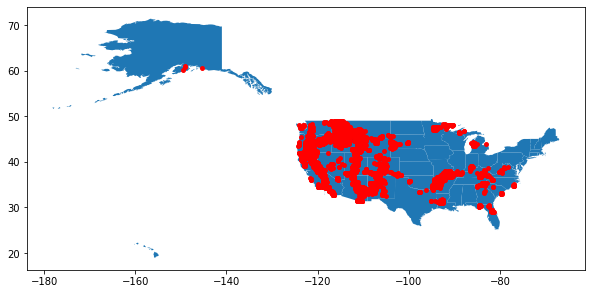

In [ ]:
from geopandas import GeoDataFrame
  
df=clean_fires_df[1:5000][['LATITUDE','LONGITUDE']]
geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]

gdf = GeoDataFrame(df, geometry=geometry) 
#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=usa.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [ ]:
temp_1000=clean_fires_df.apply(lambda x:place(x['STATE'],x['LONGITUDE'],x['LATITUDE']),axis=1)
temp_1000.count()

1880465

In [ ]:
clean_fires_df['National_park']=temp_1000
clean_fires_df['National_park'].unique()

array(['out', 'Wupatki National Monument',
       'Valles Caldera National Preserve',
       'Big South Fork National River and Recreation Area',
       'Kings Canyon National Park',
       'Great Smoky Mountains National Park',
       'Grand Canyon National Park', 'Blue Ridge Parkway',
       'Montezuma Castle National Monument', 'Death Valley National Park',
       'Great Sand Dunes National Preserve', 'Glacier National Park',
       'Redwood National Park', 'North Cascades National Park',
       'Sleeping Bear Dunes National Lakeshore',
       'Chiricahua National Monument', 'Yellowstone National Park',
       'El Malpais National Monument', 'Grand Teton National Park',
       'Lava Beds National Monument', 'Yosemite National Park',
       'Oregon Caves National Monument and Preserve',
       'Bandelier National Monument',
       'Curecanti National Recreation Area',
       'Lassen Volcanic National Park', 'Rocky Mountain National Park',
       'Sunset Crater Volcano National Monume

In [ ]:
sum(clean_fires_df['National_park']!='')-sum(clean_fires_df['National_park']=='out')

16948

In [ ]:
clean_fires_df[['OBJECTID','FIRE_SIZE_CLASS','LATITUDE','LONGITUDE','STATE','FIPS_NAME','FIRE_NAME','DISCOVERY_DATE','STAT_CAUSE_DESCR','National_park']].to_csv('/content/drive/MyDrive/cleaned_fire.csv', sep='\t')


In [ ]:
clean_fires_df.head(1)

,OBJECTID,SOURCE_REPORTING_UNIT_NAME,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,OWNER_CODE,STATE,COUNTY,FIPS_CODE,FIPS_NAME,FIRE_NAME,DISCOVERY_DATE,STAT_CAUSE_DESCR,National_park
0,1,Plumas National Forest,A,40.036944,-121.005833,USFS,5.0,CA,63.0,63.0,Plumas,FOUNTAIN,2453403.5,Miscellaneous,out


In [ ]:
p=-106.45327
q=36.00847
state="NM"
x= gpd.points_from_xy([p],[q])    
x.within(nps.geometry[1])
#place(state,p,q)

array([False])

In [ ]:
all_shapes[13].points

[(-8203649.1977, 5216256.8653),
 (-8203658.098, 5216187.3241),
 (-8203831.3235, 5216190.2731),
 (-8204030.3062, 5216154.9896),
 (-8204049.8456, 5216155.5513),
 (-8204072.5561, 5216139.2667),
 (-8204094.7051, 5216122.2208),
 (-8204116.2671, 5216104.4327),
 (-8204137.2176, 5216085.9234),
 (-8204157.5327, 5216066.7139),
 (-8204177.1889, 5216046.8259),
 (-8204196.1639, 5216026.2823),
 (-8204214.4362, 5216005.1067),
 (-8204231.9845, 5215983.3232),
 (-8204248.7893, 5215960.9567),
 (-8204264.8308, 5215938.0329),
 (-8204280.091, 5215914.5778),
 (-8204288.9659, 5215908.0833),
 (-8204298.0586, 5215901.9003),
 (-8204307.3584, 5215896.0356),
 (-8204316.8545, 5215890.4967),
 (-8204326.5353, 5215885.2901),
 (-8204336.3893, 5215880.4217),
 (-8204346.405, 5215875.8977),
 (-8204356.5701, 5215871.7233),
 (-8204366.8727, 5215867.9034),
 (-8204377.3007, 5215864.4428),
 (-8204387.8412, 5215861.345),
 (-8204398.482, 5215858.6144),
 (-8204409.2104, 5215856.2539),
 (-8204420.0136, 5215854.2667),
 (-8204430.87

In [ ]:
temp_1000.unique()

array(['out'], dtype=object)

In [ ]:
clean_fires_df['STATE'].unique()

array(['CA', 'NM', 'OR', 'NC', 'WY', 'CO', 'WA', 'MT', 'UT', 'AZ', 'SD',
       'AR', 'NV', 'ID', 'MN', 'TX', 'FL', 'SC', 'LA', 'OK', 'KS', 'MO',
       'NE', 'MI', 'KY', 'OH', 'IN', 'VA', 'IL', 'TN', 'GA', 'AK', 'ND',
       'WV', 'WI', 'AL', 'NH', 'PA', 'MS', 'ME', 'VT', 'NY', 'IA', 'DC',
       'MD', 'CT', 'MA', 'NJ', 'HI', 'DE', 'PR', 'RI'], dtype=object)

array(['out'], dtype=object)

In [ ]:
all_records[300][11]

'TX'

In [ ]:
clean_fires_df.to_csv('/content/drive/MyDrive/np_fires.csv', encoding='utf-8', index=False)

In [ ]:
from shapely import geometry
polygons=[]
for i in range(len(all_shapes)):
    poly = geometry.Polygon(all_shapes[i].points)
    polygons.append(poly)